<a target="_blank" href="https://colab.research.google.com/github/retowuest/uib-dl-2024/blob/main/nb-3.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Learning for Social Scientists

### PhD Course, University of Bergen

### **Notebook 3:**<br>Convolutional Networks

### Table of Contents
* [Introduction](#section_1)
* [Loading the Data](#section_2)
* [Data Augmentation](#section_3)
* [Training a CNN Smile Classifier](#section_4)

### Introduction <a class="anchor" id="section_1"></a>

In this notebook, we will use [PyTorch](https://pytorch.org/) to build a convolutional neural network (CNN) for smile classification of face images. We will distinguish between *smile* and *not smile*, so this is a binary classification task.

We will use the **CelebA** data set provided by [Torchvision](https://pytorch.org/vision/stable/index.html). Information about this data set is available [here](https://pytorch.org/vision/stable/datasets.html#celeba). The data set contains 202,599 images of celebrities' faces. It also contains 40 binary facial attributes for each image, including whether a celebrity is smiling or not.

Our goal is to build and train a CNN model for predicting the smile attribute from the face images. For simplicity, we will only be using a small portion of the training data (16,000 training examples) to speed up the training process. However, to reduce overfitting on such a small data set and improve generalization performance, we will use a technique called [data augmentation](https://en.wikipedia.org/wiki/Data_augmentation).

### Loading the Data <a class="anchor" id="section_2"></a>

Let's first load the data. The **CelebA** data comes in three partitions: a training set, a validation set, and a test set.

In [4]:
# Import torchvision library
import torchvision

# Set the root of the folder containing the data
image_path = "./"

# Load train, validation, and test sets
# (if you download the files with torchvision,
# set download=True in the below code snippets)
celeba_train = torchvision.datasets.CelebA(
    image_path, split="train",
    target_type="attr", download=False
)

celeba_valid = torchvision.datasets.CelebA(
    image_path, split="valid",
    target_type="attr", download=False
)

celeba_test = torchvision.datasets.CelebA(
    image_path, split="test",
    target_type="attr", download=False
)

Let's count the number of examples in each partition.

In [5]:
# Count number of examples in each partition
print("Train set:", len(celeba_train))
print("Validation set:", len(celeba_valid))
print("Test set:", len(celeba_test))

Train set: 162770
Validation set: 19867
Test set: 19962


### Data Augmentation <a class="anchor" id="section_3"></a>

Data augmentation summarizes a set of techniques we can use to deal with cases where the training data are limited. These techniques allow us to modify data, or even artificially synthesize data, and thereby improve the performance of a machine learning or deep learning model by reducing overfitting. For our image data, we will employ two different types of transformations available from the `torchvision.transforms` module:
- cropping an image to a bounding box;
- flipping an image horizontally.

We apply the above transformations in a random fashion. This means that we crop an image to a random bounding box and flip it randomly along the horizontal axis. We create a pipeline for these transformations, which we will use during the data set loading step. In addition, we define a function called `get_smile`, which will extract the `smiling` label from the `attributes` list in the data set (note that the `smiling` label is the 31st element).

In [16]:
# Import transforms module from torchvision library
from torchvision import transforms

# Define function to extract the smiling label from the attributes list
get_smile = lambda attr: attr[31]

# Define function to transform the image
# (we first randomly crop the image, then flip it randomly, and finally,
# resize it to a common size of 64x64)
transform_train = transforms.Compose([ # the Compose method composes several transformations (provided as a list) together
    transforms.RandomCrop([178, 178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64, 64]), # resize image to common size of 64x64
    transforms.ToTensor() # converts the PIL image to tensor
])

We will apply the data augmentation transformations only to the training set and not to the validation and test sets. For the validation and test sets, we will simply crop and resize the images (so that the images from all three sets have the same size).

In [17]:
# Apply transform_train function to training data set
celeba_train = torchvision.datasets.CelebA(
    image_path, split="train",
    target_type="attr", download=False,
    transform=transform_train, target_transform=get_smile
)

To illustrate how the transformations work, we apply them to each of two training examples five times and show the results.

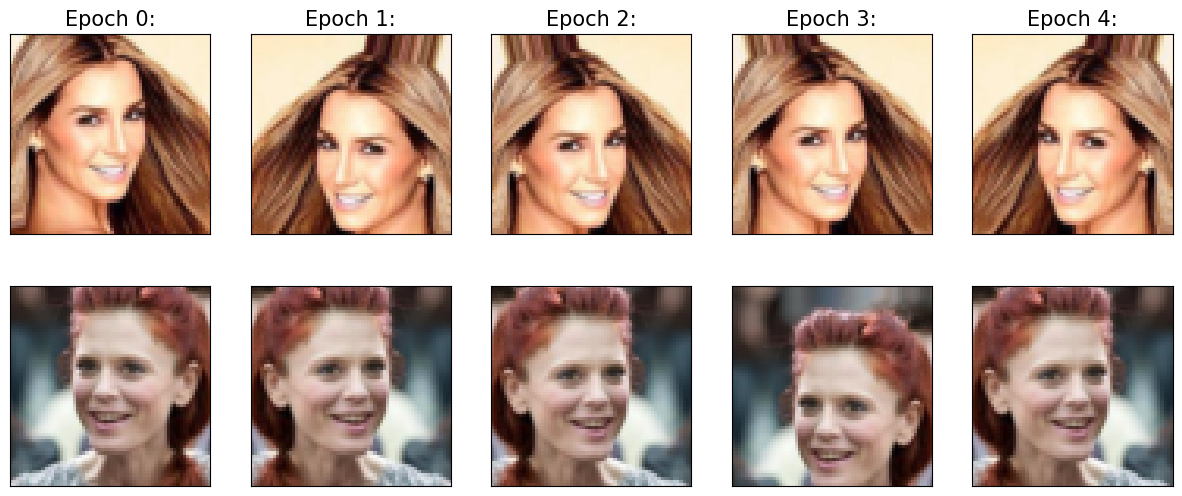

In [18]:
# Import torch library, pyplot from matplotlib library,
# and DataLoader class
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Set seed
torch.manual_seed(1)

# Define dataloader
data_loader = DataLoader(celeba_train, batch_size=2)

# Apply dataloader five times and create figure showing results
fig = plt.figure(figsize=(15, 6))
num_epochs = 5
for j in range(num_epochs):
    img_batch, label_batch = next(iter(data_loader))
    img = img_batch[0]
    ax = fig.add_subplot(2, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Epoch {j}:", size=15)
    ax.imshow(img.permute(1, 2, 0))
    
    img = img_batch[1]
    ax = fig.add_subplot(2, 5, j + 6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0))
plt.show();

Next, we will define a separate function `transform_train`, which crops and resizes images to the desired size of 64x64, and apply this function to our validation and test sets.

In [19]:
# Define function to crop and resize image
transform = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([64, 64]),
    transforms.ToTensor()
])

# Apply transform function to validation and test sets
celeba_valid = torchvision.datasets.CelebA(
    image_path, split="valid",
    target_type="attr", download=False,
    transform=transform, target_transform=get_smile
)

celeba_test = torchvision.datasets.CelebA(
    image_path, split="test",
    target_type="attr", download=False,
    transform=transform, target_transform=get_smile
)

Finally, rather than using all of the available training and validation data, we will take a subset of 16,000 training examples and 1,000 validation examples (we intentionally train our model on a small data set using data augmentation).

In [20]:
# Import Subset class
from torch.utils.data import Subset

# Pass original training and validation sets as well as the indices of the examples we want to keep
celeba_train = Subset(celeba_train,
                      torch.arange(16000))

celeba_valid = Subset(celeba_valid,
                      torch.arange(1000))

# Print length of the reduced training and validation sets
print("Training set:", len(celeba_train))
print("Validation set:", len(celeba_valid))

Training set: 16000
Validation set: 1000


Now we can create data loaders for the three data sets.

In [21]:
# Specify batch size
# (values for batch size are typically provided as a power of two that fit
#  nicely into the memory requirements of the GPU or CPU hardware, like 32,
#  64, 128, 256, ...)
batch_size = 32

# Set seed
torch.manual_seed(1)

# Create data loaders
train_dl = DataLoader(celeba_train,
                      batch_size, # when iterating through the data set, each iteration will return specified batch size
                      shuffle=True) # if argument shuffle=True, then examples are reshuffled

valid_dl = DataLoader(celeba_valid,
                      batch_size, shuffle=True)

test_dl = DataLoader(celeba_test,
                     batch_size, shuffle=True)

Now that the data loaders are ready, we can develop our CNN model and train and evaluate in on the data.

### Training a CNN Smile Classifier <a class="anchor" id="section_4"></a>

We build our CNN model with the `torch.nn` module. The network architecture is as follows.
- The CNN model receives input images of size 3x64x64 (the images have three color channels).
- The input data go through four convolution layers with a kernel size of 3x3 and padding of 1 (i.e., we add one row of zeros on the top and bottom and one column of zeros on the left and right). The first convolutional layer produces 32 channels, the second 64 channels, the third 128 channels, and the fourth 256 channels.
- The first three convolution layers are followed by max-pooling, $P_{2 \times 2}$ (see Prince 2024, 171f.).
- Two dropout layers are also included for regularization (dropout randomly clamps a subset, typically 50%, of hidden units to zero; see Prince 2024, 147ff.).

In [26]:
# Import torch.nn module
import torch.nn as nn

# Build CNN model
model = nn.Sequential()

model.add_module( # 1st convolutional layer
    "conv1", # name of module
    nn.Conv2d(
        in_channels=3,
        out_channels=32,
        kernel_size=3,
        padding=1
    )
)
model.add_module("relu1", nn.ReLU()) # add ReLU activation function
model.add_module("pool1", nn.MaxPool2d(kernel_size=2)) # add pooling layer
model.add_module("dropout1", nn.Dropout2d(p=0.5)) # add dropout layer

model.add_module( # 2nd convolutional layer
    "conv2",
    nn.Conv2d(
        in_channels=32,
        out_channels=64,
        kernel_size=3,
        padding=1
    )
)
model.add_module("relu2", nn.ReLU())
model.add_module("pool2", nn.MaxPool2d(kernel_size=2))
model.add_module("dropout2", nn.Dropout(p=0.5))

model.add_module( # 3rd convolutional layer
    "conv3",
    nn.Conv2d(
        in_channels=64,
        out_channels=128,
        kernel_size=3,
        padding=1
    )
)
model.add_module("relu3", nn.ReLU())
model.add_module("pool3", nn.MaxPool2d(kernel_size=2))

model.add_module( # 4th convolutional layer
    "conv4",
    nn.Conv2d(
        in_channels=128,
        out_channels=256,
        kernel_size=3,
        padding=1
    )
)
model.add_module("relu4", nn.ReLU())

To see the shape of the output, let's apply these layers using a toy batch input of four images.

In [27]:
# Create toy batch input
x = torch.ones((4, 3, 64, 64))

# Apply the layers and print the shape of the output
model(x).shape

torch.Size([4, 256, 8, 8])

We can see that there are 256 channels of size 8x8 (the first element in `torch.Size([4, 256, 8, 8])` refers to the batch size).

We now add a *global average-pooling* layer, which computes the average of each channel separately. After applying the global average-pooling layer (and after squeezing with `nn.Flatten`), we expect the output to have size [*batch size*x256].

In [28]:
# Add global average-pooling layer to model
model.add_module("pool4", nn.AvgPool2d(kernel_size=8))
model.add_module("flatten", nn.Flatten())

# Apply layers again to our toy batch input and print shape of the output
model(x).shape

torch.Size([4, 256])

Finally, we can add a fully-connected layer to get a single output unit. Here we specify the activation function to be sigmoid in order to obtain a probability bounded between 0 and 1.

In [29]:
# Add fully-connected layer and sigmoid activation function
model.add_module("fc", nn.Linear(256, 1))
model.add_module("sigmoid", nn.Sigmoid())

# Apply layers again to our toy batch input and print shape of the output
model(x).shape

torch.Size([4, 1])

We can also take a look at the network architecture.

In [30]:
# Show model
model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

The next step is to choose a loss function and an optimizer.

For binary classification, we can use the binary cross-entropy loss function (`nn.BCELoss`) (the binary cross-entropy loss function is the negative log-likelihood with a sigmoid function, see Prince 2024, 66).

As our optimizer, we choose to use the Adam optimizer (see Prince 2024, 88ff.).

In [31]:
# Specify loss function and optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

We can now train the model.

In [32]:
# Define function for model training
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs # list for the training loss after each epoch
    accuracy_hist_train = [0] * num_epochs # list for the training accuracy after each epoch
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train() # this function sets the model in training mode
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch.float())
            loss.backward() # uses backpropagation to compute the current gradients
            optimizer.step() # updates the parameters based on the gradients
            optimizer.zero_grad() # resets gradients to zero
            loss_hist_train[epoch] += loss.item() * y_batch.size(0) # item() returns tensor value as standard Python number; size(0) creates a 1-dimensional tensor with no elements
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval() # this function sets the model in evaluation mode
        with torch.no_grad(): # disables gradient computation
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_train[epoch] /= len(valid_dl.dataset)
        
        print(f"Epoch {epoch+1} accuracy: "
              f"{accuracy_hist_train[epoch]:.4f} val_accuracy: "
              f"{accuracy_hist_valid[epoch]:.4f}")
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

Next, we will train the CNN model for 30 epochs and use the validation set that we created for monitoring the learning process.

In [33]:
# Set seed
torch.manual_seed(1)

# Specify number of epochs
num_epochs = 30

# Train model using the training function defined above
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.0005 val_accuracy: 514.0000
Epoch 2 accuracy: 0.0005 val_accuracy: 514.0000
Epoch 3 accuracy: 0.0005 val_accuracy: 514.0000
Epoch 4 accuracy: 0.0005 val_accuracy: 514.0000


KeyboardInterrupt: 